# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher_Linux_NoVis/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 4. Training

In [6]:
from collections import deque
from ddpg_agent import Agent
import torch

mean_score_objective=30.0

In [7]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []

    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]

        agent.reset()
        score = 0
        for t in range(max_t):
            # takes action
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            
            # Get state from environment
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_deque.append(score)
        scores.append(score)
        #print('\rEpisode {}\tLast Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tLast Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))

        if np.mean(scores_deque)>=mean_score_objective:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break

    return scores

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, fc1_units=400, fc2_units=300, batch_size=128, random_seed=667)
scores = ddpg()

Episode 100	Last Score: 3.88	Average Score: 1.79
Episode 200	Last Score: 8.32	Average Score: 6.32
Episode 300	Last Score: 14.74	Average Score: 9.57
Episode 400	Last Score: 15.97	Average Score: 12.26
Episode 500	Last Score: 20.62	Average Score: 18.10
Episode 600	Last Score: 22.28	Average Score: 24.80

Environment solved in 593 episodes!	Average Score: 30.01


### 5. Plotting the results

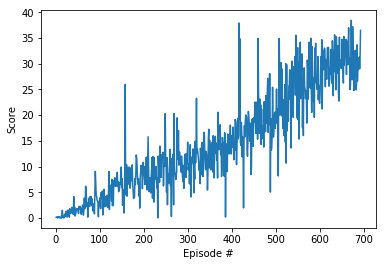

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt 

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.show()
plt.savefig('results.png')

When finished, close the environment.

In [ ]:
env.close()